We compare two different weighting approaches for integrating micro- and macro-averaged silhouette scores into a composite metric:

- Aggressive Weighting Approach (our approach in the main StatisticalCompositeSilhouette): This method gives stronger preference to the superior metric (S_micro or S_macro) based on statistical significance, while still incorporating the other to a lesser extent.

- Balanced Weighting Approach: This method adjusts the weights based solely on the average difference of the paired silhouette scores, leading to a more conservative weighting scheme.

The "aggressive" weighting approach identifies more frequently the ground truth number of clusters when at least one of the average micro or macro silhouette scores aligns with the true k. The method prioritizes the dominant clustering quality indicator more decisively, leading to better resolution of the true cluster structure in cases where clustering performance varies across micro- and macro-level evaluations.

On the other hand, the "balanced" weighting approach tends to smooth out differences between the two silhouette scores, leading to a more moderate evaluation. While this may be preferable in cases with highly uncertain clustering structures, it is less effective at consistently selecting the ground truth when one of the sample-average silhouette scores already captures it.

Findings suggest that our Aggressive Weighting Approach is a more effective heuristic for centroid-based clustering evaluation, particularly in datasets with imbalanced clusters or subtle clustering structures where one silhouette measure may dominate the other.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import wilcoxon
from sklearn.utils import resample
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

class CS_AggresiveBalanaced:
    def __init__(self,
                 data,
                 ground_truth=None,
                 k_values=range(2, 11),
                 num_samples=100,
                 sample_size=1000,
                 random_state=42):
        """
        Parameters:

        - data : ndarray or DataFrame, shape (n_samples, n_features)
                 The input dataset.

        - k_values : iterable, default=range(2, 11)
                    The range of cluster numbers to evaluate.

        - num_samples : int, default=100
                        Number of sampling iterations per k.

        - sample_size : int, default=1000
                        Number of data points to sample in each iteration.

        - random_state : int, default=42
                         Seed for reproducibility.
        """
        self.data = data.astype(np.float32)
        self.k_values = k_values
        self.num_samples = num_samples
        self.sample_size = sample_size
        self.random_state = random_state
        self.ground_truth = ground_truth

        # Empty list to store results
        self._results = []

        # Placeholder for the results DataFrame
        self.results_df = pd.DataFrame()

    def SilhouetteMicro(self, X, labels):
        """
        Parameters:

        - X : array-like of shape (n_samples, n_features)
              Input data points.

        - labels : array-like of shape (n_samples,)
                   Cluster labels for each sample.

        Returns:

        - The micro-averaged silhouette score (float).
        """
        return silhouette_score(X, labels)

    def SilhouetteMacro(self, X, labels):
        """
        Parameters:

        - X : array-like of shape (n_samples, n_features)
              Input data points.

        - labels : array-like of shape (n_samples,)
                   Cluster labels for each sample.

        Returns:

        The macro-averaged silhouette score (float).
        """
        silhouette_vals = silhouette_samples(X, labels)
        unique_labels = np.unique(labels)
        cluster_means = [
            np.mean(silhouette_vals[labels == lbl]) for lbl in unique_labels
        ]
        return np.mean(cluster_means) if cluster_means else 0

    def evaluate_sample(self, k, i):
        """
        Processes one iteration of subsampled clustering for a specified number of clusters.
        It performs data sampling, applies the clustering algorithm with k clusters, and computes both
        the micro-averaged and macro-averaged Silhouette scores. It then returns these scores along with
        their difference (S_micro - S_macro).

        Parameters:
        - k : int
              Number of clusters.
        - i : int
              Iteration index.

        Returns:
        - (smicro, smacro, difference) (tuple of float)
        """
        # Unique random state for each sample
        seed = self.random_state + i

        # Uniformly sampling without replacement
        sampled_data = resample(
            self.data,
            n_samples=self.sample_size,
            replace=False,
            random_state=seed
        )

        # KMeans clustering (n_init=1 as we have many initializations in the st. test already)
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=1)
        labels = kmeans.fit_predict(sampled_data)

        # Compute S_micro (micro-averaged silhouette score)
        smicro = self.SilhouetteMicro(sampled_data, labels)

        # Compute S_macro (macro-averaged silhouette score)
        smacro = self.SilhouetteMacro(sampled_data, labels)

        # Compute difference (paired differences used in wilcoxon test)
        difference = smicro - smacro

        return smicro, smacro, difference

    def evaluate_aggresive(self):
        """
        Our default weighting approach in the main StatisticalCompositeSilhouette
        """

        for k in self.k_values:
            # Parallel execution of samples for current k
            results = Parallel(n_jobs=-1)(
                delayed(self.evaluate_sample)(k, i) for i in range(self.num_samples)
            )

            # Unpack results
            smicro_list, smacro_list, differences = zip(*results)
            smicro_list = np.array(smicro_list)
            smacro_list = np.array(smacro_list)
            differences = np.array(differences)

            # Perform Wilcoxon Signed-Rank Test - at least one non-zero difference
            if np.all(differences == 0):
                p_value = 1.0
            else:
                try:
                    stat, p_value = wilcoxon(differences)
                except Exception as e:
                    print(f"Wilcoxon test failed for k={k}: {e}")
                    p_value = 1.0  # If the test cannot be performed

            if p_value <= 0.05:
                significance = '+'
            elif p_value > 0.05:
                significance = '-'
            else:
                significance = 'N/A'

            # Compute average S_micro and S_macro and their difference across all samples
            mean_diff = np.mean(differences)
            avg_smicro = np.mean(smicro_list)
            avg_smacro = np.mean(smacro_list)

            # Clip mean difference in silhouette scale: [-1,1]
            alpha = np.clip(mean_diff, -1.0, 1.0)

            # Map clipped difference to [0.5, 1]
            epsilon = (1+ np.abs(alpha)) / 2 # Weights will map epsilon to [0.75,1]

            if significance == '+':
                if alpha > 0: # S_micro dominates (more weight to Smicro)
                    w_micro = (1 + epsilon) / 2 # in (0.75, 1]
                    w_macro = 1 - w_micro # in [0, 0.25)
                elif alpha < 0: # S_macro dominates (more weight to Smacro)
                    w_macro = (1 + epsilon) / 2
                    w_micro = 1 - w_macro
                else: # st. significant with zero mean difference (equal weights)
                    w_micro = 0.5
                    w_macro = 0.5
            else: # not st. significant result (equal weights)
                w_micro = 0.5
                w_macro = 0.5

            # Weighted (convex) combination of (sample-)average micro and macro
            Sconvex = w_micro * avg_smicro + w_macro * avg_smacro

            result = {
                'number of clusters (k)': k,
                'p-value': p_value,
                'St. significance': significance,
                'Mean difference': mean_diff,
                'avg S_micro': avg_smicro,
                'avg S_macro': avg_smacro,
                'w_micro': w_micro,
                'w_macro': w_macro,
                'S_micro-macro': Sconvex
            }

            self._results.append(result)

        self.results_df = pd.DataFrame(self._results)

    def evaluate_balanced(self):
        """
        A more balanced weighting approach.
        """

        for k in self.k_values:
            # Parallel execution of samples for current k
            results = Parallel(n_jobs=-1)(
                delayed(self.evaluate_sample)(k, i) for i in range(self.num_samples)
            )

            # Unpack results
            smicro_list, smacro_list, differences = zip(*results)
            smicro_list = np.array(smicro_list)
            smacro_list = np.array(smacro_list)
            differences = np.array(differences)

            # Perform Wilcoxon Signed-Rank Test - at least one non-zero difference
            if np.all(differences == 0):
                p_value = 1.0
            else:
                try:
                    stat, p_value = wilcoxon(differences)
                except Exception as e:
                    print(f"Wilcoxon test failed for k={k}: {e}")
                    p_value = 1.0  # If the test cannot be performed

            if p_value <= 0.05:
                significance = '+'
            elif p_value > 0.05:
                significance = '-'
            else:
                significance = 'N/A'

            # Compute average S_micro and S_macro and their difference across all samples
            mean_diff = np.mean(differences)
            avg_smicro = np.mean(smicro_list)
            avg_smacro = np.mean(smacro_list)

            # Clip mean difference in silhouette scale: [-1,1]
            alpha = np.clip(mean_diff, -1.0, 1.0)

            if significance == '+':
                if alpha > 0: # S_micro dominates (more weight to Smicro)
                    w_micro = (1 + alpha) / 2
                    w_macro = 1 - w_micro
                elif alpha < 0: # S_macro dominates (more weight to Smacro)
                    w_macro = (1 + alpha) / 2
                    w_micro = 1 - w_macro
                else: # st. significant with zero mean difference (equal weights)
                    w_micro = 0.5
                    w_macro = 0.5
            else: # not st. significant result (equal weights)
                w_micro = 0.5
                w_macro = 0.5

            # Weighted (convex) combination of (sample-)average micro and macro
            Sconvex = w_micro * avg_smicro + w_macro * avg_smacro

            result = {
                'number of clusters (k)': k,
                'p-value': p_value,
                'St. significance': significance,
                'Mean difference': mean_diff,
                'avg S_micro': avg_smicro,
                'avg S_macro': avg_smacro,
                'w_micro': w_micro,
                'w_macro': w_macro,
                'S_micro-macro': Sconvex
            }

            self._results.append(result)

        self.results_df = pd.DataFrame(self._results)

    def get_results_dataframe(self):
        """
        Retrieve the results as a Pandas DataFrame.

        Returns:
        - results_df: DataFrame
            The DataFrame containing evaluation metrics for each k.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Run the evaluate() method first.")
        return self.results_df.set_index('number of clusters (k)', inplace=False)

---

### Example - Synthetic Dataset with overlapping clusters of different sizes and densities

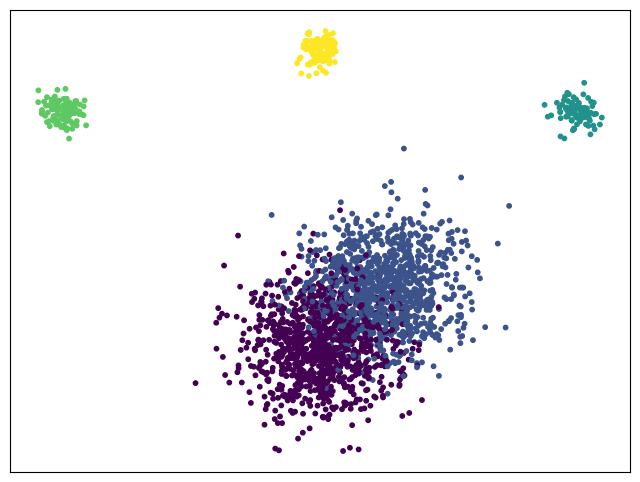

In [2]:
cluster_sizes = [1000, 1000, 100, 100, 100]  # 2 large, 3 small
centers = [
    (0, 0),   # large cluster #1
    (3, 3),   # large cluster #2 (not too far from #1, so they merge in small k)
    (12, 12), # small cluster #1
    (-12, 12),# small cluster #2
    (0, 15),  # small cluster #3
]
stds = [1.8, 1.8, 0.5, 0.5, 0.5]  # bigger std for large clusters, smaller for small

X, y = make_blobs(
    n_samples=cluster_sizes,
    centers=centers,
    cluster_std=stds,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=10)
plt.xticks([])
plt.yticks([])
plt.show()


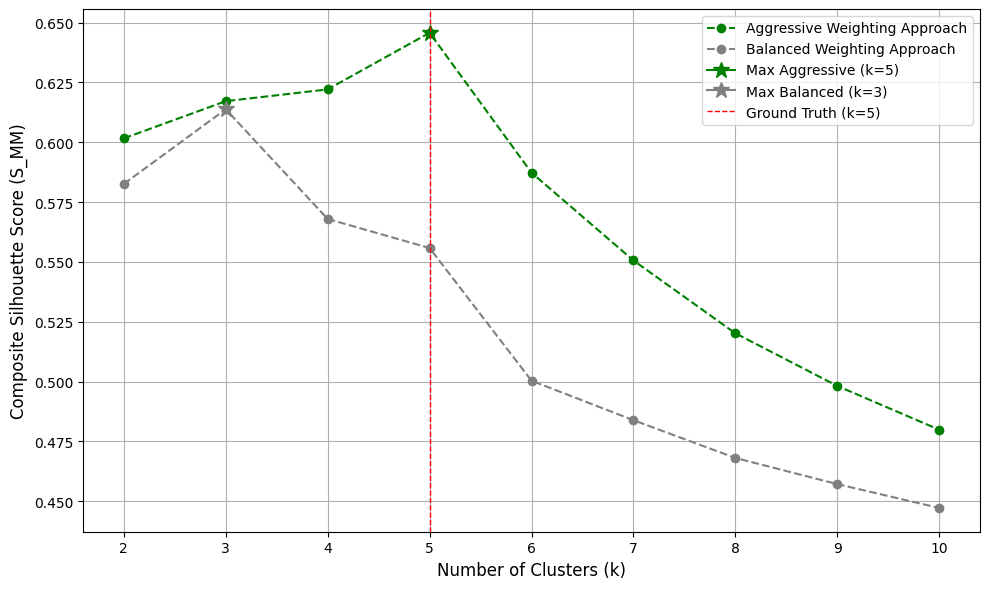

In [3]:
# Aggressive weighting approach
evaluator_agg = CS_AggresiveBalanaced(data=X_scaled, ground_truth=5, k_values=range(2, 11),
                                    num_samples=100, sample_size=500, random_state=42)
evaluator_agg.evaluate_aggresive()
results_agg = evaluator_agg.get_results_dataframe()

# Balanced weighting approach
evaluator_bal = CS_AggresiveBalanaced(data=X_scaled, ground_truth=5, k_values=range(2, 11),
                                    num_samples=100, sample_size=500, random_state=42)
evaluator_bal.evaluate_balanced()
results_bal = evaluator_bal.get_results_dataframe()

# (S_mM) across k for both approaches
plt.figure(figsize=(10,6))
plt.plot(results_agg.index, results_agg['S_micro-macro'], marker='o', linestyle='--', color='green',
         label='Aggressive Weighting Approach')
plt.plot(results_bal.index, results_bal['S_micro-macro'], marker='o', linestyle='--', color='gray',
         label='Balanced Weighting Approach')

max_agg_k = results_agg['S_micro-macro'].idxmax()
max_agg_val = results_agg.loc[max_agg_k, 'S_micro-macro']
plt.plot(max_agg_k, max_agg_val, marker='*', markersize=12, color='green',
         label=f'Max Aggressive (k={max_agg_k})')

max_bal_k = results_bal['S_micro-macro'].idxmax()
max_bal_val = results_bal.loc[max_bal_k, 'S_micro-macro']
plt.plot(max_bal_k, max_bal_val, marker='*', markersize=12, color='gray',
         label=f'Max Balanced (k={max_bal_k})')

if evaluator_agg.ground_truth is not None:
    plt.axvline(x=evaluator_agg.ground_truth, color='red', linestyle='--', linewidth=1,
                label=f'Ground Truth (k={evaluator_agg.ground_truth})')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Composite Silhouette Score (S_MM)', fontsize=12)
plt.xticks(list(results_agg.index))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()